# Neural networks for 4-point contact interaction in bosonic string field theory

Authors: Harold Erbin, Atakan Hilmi Fırat
arxiv: 2211.09129

In this notebook, we show how to load the neural networks needed to compute the 4-point classical contact interaction for bosonic string field theory. The first network computes the accessory parameter as a function of the modulus of 4-punctured spheres. The second network determines if modulus is in the fundamental vertex region. We refer to the paper arxiv:[2211.09129](https://arxiv.org/abs/2211.09129) for definitions and methodology.

The code uses [Jax](https://jax.readthedocs.io) and [Flax](https://flax.readthedocs.io) to define the neural networks.

In [ ]:
from typing import Sequence
from pathlib import Path
import json

import numpy as np

import jax
import jax.numpy as jnp
from jax import random

%matplotlib inline
import matplotlib.pyplot as plt

import flax
import flax.linen as nn
from flax import serialization

key = random.PRNGKey(0)


Define useful constants: where are the data located, the dimension of the moduli space, and the distinguished point $Q = \mathrm{e}^{\mathrm{i} \pi / 3}$.

In [ ]:
data_path = Path(".").resolve().parent / "networks"

xi_dim = 1

Q = jnp.exp(1j * jnp.pi / 3)

[]

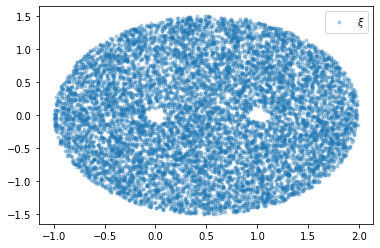

In [54]:
def data_generator_circle(key, samples, radius=1.5, excision=0.1):
    """
    Generate random points uniformly in a disk of the moduli space.

    Points are generated randomly in a ball of radius `radius` center at 1/2, and excluding disks
    of radius `excision` centered at the punctures 0 and 1. The number of points is defined by
    `samples`.
    """

    key1, key2 = random.split(key, 2)
    
    # collect more points than needed, since we exclude them latter
    ratio = 1.2
    up_samples = int(ratio * samples)

    length = random.uniform(key1, (up_samples, xi_dim), minval=0, maxval=1)
    angle = 2 * jnp.pi * random.uniform(key2, (up_samples, xi_dim), minval=0, maxval=1)

    points = 1/2 + radius * np.sqrt(length) * jnp.exp(1j * angle)

    # remove points around punctures
    points = points[(jnp.abs(points) > excision) & (jnp.abs(points - 1) > excision)]

    assert len(points) >= samples

    return points[:samples].reshape(-1, xi_dim)


xi = data_generator_circle(key, 10000, radius=1.5, excision=0.1)
fig, ax = plt.subplots()
ax.plot(xi.real, xi.imag, ".", alpha=0.3, label=r"$\xi$")
ax.legend()
plt.plot()

In [3]:
class AccParamNetwork(nn.Module):
    """
    Neural network computing the accessory parameter.

    This neural network is fully connected, the number of hidden layers is given by `features`, and
    it uses `ELU` activation functions, each with identical parameter `alpha`.
    """

    features: Sequence[int]
    alpha: float

    @nn.compact
    def __call__(self, x):

        for feat in self.features[:-1]:
            x = nn.Dense(feat, param_dtype=jnp.complex64)(x)
            x = nn.elu(x.real, alpha=self.alpha) + 1j * nn.elu(x.imag, alpha=self.alpha)
        
        x = nn.Dense(self.features[-1], name="output", param_dtype=jnp.complex64)(x)
        
        return x


class VertexNetwork(nn.Module):
    """
    Neural network computing the probability for point to be in the vertex region.

    This neural network is fully connected, the number of hidden layers is given by `features`, and
    it uses `ELU` activation functions, each with identical parameter `alpha`.
    """

    features: Sequence[int]
    alpha: float

    @nn.compact
    def __call__(self, x):

        x = jnp.concatenate([x.real, x.imag], axis=1).astype(jnp.float32)

        for feat in self.features:
            x = nn.Dense(feat)(x)
            x = nn.elu(x, alpha=self.alpha)
        
        x = nn.Dense(2, name="output")(x)
        
        return x


networks_dict = {
    "accessory_parameter": AccParamNetwork,
    "vertex_region": VertexNetwork
}

In [8]:
def initialized(key, model_cls, hyperparameters):
    """
    Initialize a neural network given a class and hyperparameters.
    """

    if model_cls is AccParamNetwork:
        input_dim = xi_dim
        output_dim = xi_dim
    elif model_cls is VertexNetwork:
        input_dim = xi_dim
        output_dim = 2

    dense_layers = hyperparameters.get("dense_layers", [output_dim])
    alpha = hyperparameters.get("alpha", 1.0)

    model = model_cls(features=dense_layers, alpha=alpha)

    batch = jnp.ones((1, input_dim))
    initial_params = model.init(key, batch)

    return model, initial_params


def load_model(path):
    """
    Create a neural network using pre-trained weights.

    The path points to a json file storing the hyperparamters and the model name. There must be
    another file with the same name but extension `.weights` describing the network parameters.
    """

    with open(path, 'r') as f:
        hyperparameters = json.load(f)

    model_cls = networks_dict.get(hyperparameters["model"])

    model, params = initialized(random.PRNGKey(0), model_cls, hyperparameters)

    with open(path.with_suffix(".weights"), 'rb') as f:
        params = serialization.from_bytes(params, f.read())
    
    return model, params, hyperparameters


We load the two models and define shortcut functions.

In [11]:
acc_model, acc_params, acc_hyperparameters = load_model(data_path / "sphere_04_accessory_nn.json")
ver_model, ver_params, ver_hyperparameters = load_model(data_path / "sphere_04_vertex_nn.json")


@jax.jit
def predict_a(xi):
    """
    Predict the accessory parameter.

    Use the model and parameters loaded above. It also accepts non-array inputs (such as scalars
    or lists) and squeezes the output if possible.
    """

    xi = jnp.array(xi).reshape(-1, 1)

    return jnp.squeeze(acc_model.apply(acc_params, xi))


@jax.jit
def predict_prob(xi):
    """
    Predict the probability to be in the vertex region.

    Use the model and parameters loaded above. It also accepts non-array inputs (such as scalars
    or lists) and squeezes the output if possible.
    """

    xi = jnp.array(xi).reshape(-1, 1)

    return jnp.squeeze(nn.softmax(ver_model.apply(ver_params, xi))[:, 1])

Compute the accessory parameters for the points $\xi = 1/2, 2, Q$.

In [12]:
a = predict_a(1/2)
print(f"a(1/2) = {a:.4f}")

a = predict_a([2, Q])
print(f"a(2) = {a[0]:.4f}")
print(f"a(Q) = {a[1]:.4f}")

a(1/2) = 2.0000-0.0000j
a(2) = 4.0003+0.0002j
a(Q) = 2.0007+1.1540j


Compute the probability for the points $\xi = 0, 1/2, Q$.

In [17]:
p = predict_prob(1/2)
print(f"prob(1/2) = {p:.2%}")

p = predict_prob([0, Q])
print(f"prob(0) = {p[0]:.2%}")
print(f"prob(Q) = {p[1]:.2%}")

prob(1/2) = 22.52%
prob(0) = 0.00%
prob(Q) = 100.00%


Plot the predictions of the network for $\xi \in \operatorname{Re} \xi$ and compare with the analytic solution.

[]

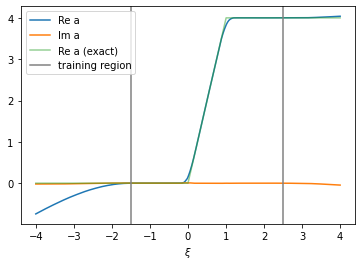

In [56]:
def real_a_sol(xi):
    """
    Analytic solution for the accessory parameter for xi on the real line.
    """

    if xi < 0:
        return 0
    elif xi > 1:
        return 4
    else:
        return 4 * xi


grid = 10000
xi = np.linspace(-4, 4, grid)
min_xi_train = -1.5
max_xi_train = 2.5

a = predict_a(xi)

fig, ax = plt.subplots()

ax.plot(xi, a.real, label="Re a")
ax.plot(xi, a.imag, label="Im a")

a_exact = np.array([real_a_sol(xi) for xi in xi])
ax.plot(xi, a_exact, label="Re a (exact)", alpha=0.5)

ax.axvline(min_xi_train, color="grey", label="training region")
ax.axvline(max_xi_train, color="grey")

ax.set_xlabel(r"$\xi$")
ax.legend()
plt.plot()


Plot the probability to be in the vertex region for a set of random points in a disk of radius 2.5.

[]

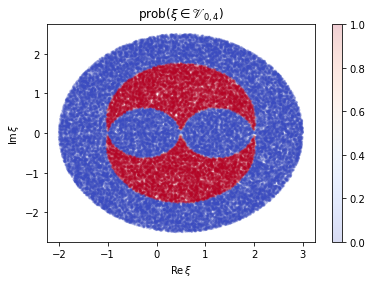

In [57]:
n_samples = 50000
key, subkey = random.split(key, 2)

xi = data_generator_circle(subkey, radius=2.5, samples=n_samples, excision=0.)
prob_in = predict_prob(xi)

fig, ax = plt.subplots()
img = ax.scatter(xi.real, xi.imag, c=prob_in, cmap="coolwarm", alpha=0.2, s=3)
ax.set_xlabel(r"$\mathrm{Re}\, \xi$")
ax.set_ylabel(r"$\mathrm{Im}\, \xi$");
ax.set_title(r'$\mathrm{prob}(\xi \in 𝒱_{0,4})$')
fig.colorbar(img)
plt.plot()

One can define the boundary as points for which the neural network is not sure whether they are inside or outside the vertex region (confusion). We plot such a graph where we take the interval is set by `prob_cutoff`.

[]

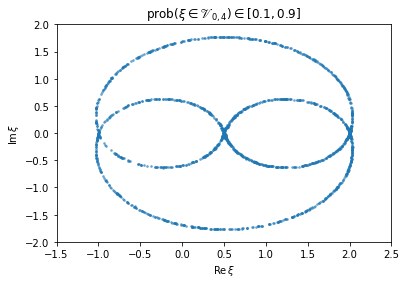

In [58]:
def plot_boundary(xi, cutoff, fund_domain=False):
    prob_min = 0.5 - cutoff
    prob_max = 0.5 + cutoff

    prob_in = predict_prob(xi)
    boundary = xi[(prob_min < prob_in) & (prob_in < prob_max)]

    if fund_domain is True:
        boundary = boundary[jnp.ravel((jnp.imag(boundary) >= 0) & (jnp.real(boundary) <= 1/2) & (jnp.abs(boundary) >= 1))]

    fig, ax = plt.subplots()

    ax.scatter(boundary.real, boundary.imag, alpha=0.5, s=3)
    
    if fund_domain is True:
        ax.set_xlim(-1.5, 1)
        ax.set_ylim(0, 2)
    else:
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-2, 2)

    ax.set_xlabel(r"$\mathrm{Re}\, \xi$")
    ax.set_ylabel(r"$\mathrm{Im}\, \xi$");
    ax.set_title(r"$\mathrm{prob}(\xi \in 𝒱_{0,4}) \in [%.2g, %.2g]$" % (prob_min, prob_max))

    return fig


n_samples = 200000
prob_cutoff = 0.4
key, subkey = random.split(key, 2)

xi = data_generator_circle(subkey, radius=2.5, samples=n_samples, excision=0.3)
fig = plot_boundary(xi, prob_cutoff)
plt.plot()